<a href="https://colab.research.google.com/github/Hsuyeon01/ESAA/blob/main/0516_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 6. XGBoost(eXtra Gradient Boost) ##

**XGBoost 개요**

- 분류에 잇어서 일반적으로 다른 머신러닝보다 뛰어난 예측 성능을 나타냄 (일반적으로 분류와 회귀 영역에서)
- GBM에 기반하고 있찌만, GBM의 단점인 느린 수행 시간 및 과적합 규제 부재 등의 문제를 해결, 병렬 CPU 환경에서 병렬 학습이 가능해 기존 GBM보다 빠르게 학습을 완료할 수 있음
- 과적합 규제 : 표준 GBM의 경우 과적합 규제 기능이 없으나 XGBoost는 자체에 과적합 규제 기능으로 과적합에 좀 더 강한 내구성을 가질 수 있음
- Tree pruning : GBM과 마찬가지고 max_depth 파라미터로 분할 깊이를 조정하기도 하지만 tree pruning으로 더 이상 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 더 줄이는 추가적인 장점 가짐
- 자체 내장된 교차 검증 : 반복 수행 시마다 내부적으로 학습 데이터 세트와 평가 데이터 세트에 대한 교차 검증을 수행해 최적화된 반복 수행 횟수를 가질 수 있음
- 결손값 자체 처리

- XGBoost는 사이킷런 프레임 워크를 기반으로 한 것이 아니기에 사이킷런 고유의 아키텍처가 적용될 수 없으며 다양한 유틸리티와 함께 사용될 수 없음
- XGBoost에 사이킷런 래퍼 클래스를 사용히면 표준 사이킷런 개발 프로세스 및 다양한 유틸리티 활용할 수 있음


In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier

### 파이썬 래퍼 XGBoost 하이퍼 파라미터 ###

- 일반 파라미터 : 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
- 부스터 파라미터 : 트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭
- 학습 태스크 파라미타 : 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터

**주요 일반 파라미터**

- booster : gbtree(tree based model) 또는 gblinear(linear model) 선택, 디폴트는 gbtree
- silent : 디폴트는 0, 출력 메시지를 나타내고 싶지 않을 경우 1
- nthread : CPU의 실행 스레드 개수를 조정하며, 디폴트는 CPU의 전체 스레드를 다 사용하는 것, 멀티 코어/스레드 CPU 시스템에서 전체 CPU를 사용하지 않고 일부 CPU만 사용해 ML 애플리케이션을 구동하는 경우에 변경

**주요 부스터 파라미터**

- eta[dafault =0.3, alias : learning_rate] : GBM의 학습률과 같은 파라미터, 0과 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값
    - 파이썬 래퍼 기반의 xgboost를 이용할 경우 디폴트는 0.3
    - 사이킷런 래퍼 클래스를 이용할 경우 eta는 learning_rate 파라미터로 대체되며 디폴트는 0.1
    - 일반적으로 0.01~0.2 사이의 값을 선호
- num_boost_rounds : n_estimator와 같은 파라미터
- min_child_weight[default=1] : 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합, 클수록 분할을 자제, 과적합 조절하기 위해 사용
- gamma[default=0, alias:min_split_loss] : 트리의 리프 토드를 추가적을 나눌 지 말지 결정할 최소 손실 감소 값, 해당 값보다 큰 손실이 감소된 경우에 리프 노드를 분리, 값이 클수록 과적합 감소 효과가 있음
- max_depth[default=6] : 트리 기반 알고리즘의 max_depth와 같음, 0을 지정하면 깊이에 제한이 없음, 높으면 특정 피처 조건에 특화되어 롤 조건이 만들어지므로 과적합 가능성이 높아지며 보통은 3~10 사이의 값을 적용
- sub_sample[default=1] : GBM의 subsample과 동일, 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율 지정, 0.5로 지정하면 전체 데이터의 절반을 트리를 생선하는 데 사용, 0에서 1사이의 값이 가능하나 일반적으로 0.5~1 사이의 값을 사용
- colsample_bytree[default=1] : max_features와 유사, 트리 생성에 필요한 피처를 임의로 샘플링, 매우 많은 피처가 있는 경우 과적합을 조정하는 데 적용
- lambda[default=,alias:reg_lambda] : L2 Regularization 적용 값, 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 감소 효과가 있음
- alpha[default = 0, alias : reg_alpha] : L1 Regularization 적용 값, 피처 개수가 많을수록 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음
- scale_pos_weight[default=1] : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터

**학습 태스크 파라미터**

- objective : 최솟값을 가져야할 손실함수 정의, 주로 사용되는 손실함수는 이진분류인지 다중 분류인지에 따라 달라짐
- binary:logistic : 이진 분류일 때 적용
- multi:softmax : 다중 분류일 때 적용, 레이블 클래스의 개수 num_class 파라미터 지정해야 함
- multi:softprob : 개별 레이블 클래스의 해당되는 예측 확률 반환
- eval_metric : 검증에 사용되는 함수 정의, 회귀인 경우 rmse, 분류인 경우 error
     - rmse : root mean squared error
     - mae : mean absolute error
     - logloss : negative log-likihood
     - error : Binary classification error rate(0.5 threshold)
     - merror : multiclass classification error rate
     - mlogloss : multiclass logloss
     - auc : area under the curve
     

**과적합 문제가 심각하다면**

- eta 값을 낮춤, num_round는 반대로 높여줘야 함
- max_depth 값을 낮춤
- min_child_weight 값을 높임
- gamma 값을 높임
- subsample과 colsample_bytree를 조정

조기 중단 기능

- n_estimators에 지정한 부스팅 반복 횟수에 도달하지 않더라도 예측 오류가 더 이상 개선되지 않으면 반복을 끝까지 수행하지 않고 중지해 수행시간을 개선할 수 있음

In [ ]:
import xgboost
print(xgboost.__version__)

1.5.2


### 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측 ###

In [ ]:
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns = dataset.feature_names)
cancer_df['target'] = y_label
cancer_df.head(3) # 악성인 malignant가 0, 양성인 benign이 1값

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [ ]:
# 레이블 값의 분포
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [ ]:
# 전체 데이터 중 80%는 학습용, 20%는 테스트용
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                   test_size=0.2, random_state=156)

print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


DMatrix

- DMatrix는 주로 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트
- DMatirx의 주요 파라미터는 data(v피처 데이터 세트)와 label(분류의 경우에는 레이블 데이터 세트, 회귀의 경우는 숫자형인 종속값 데이터 세트)
- 넘파이 외에 libsvm txt 포맷 파일, xgboost 이진 버퍼 파일을 파라미터로 입력받아 변환할 수 있음

In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [ ]:
params = {
    'max_depth' :3,
    'eta' : 0.1,
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'early_stoppings':100
}
num_rounds = 400

조기중단은 xgboost의 train() 함수에 early_stopping_rounds 파라미터를 입력하여 설정

- eval_set는 성능 평가를 수행할 평가용 데이터 세트를 설정
- eval_metric은 평가 세트에 적용할 성능 평가 방법, 분류일 경우 주로 'error', 'logloss' 사용

In [ ]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval로 명기'
wlist = [(dtrain, 'train'), (dtest, 'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params, dtrain=dtrain, num_boost_round = num_rounds, 
                     early_stopping_rounds=100, evals=wlist)

[10:57:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.60969	eval-logloss:0.61352
[1]	train-logloss:0.54080	eval-logloss:0.54784
[2]	train-logloss:0.48375	eval-logloss:0.49425
[3]	train-logloss:0.43446	eval-logloss:0.44799
[4]	train-logloss:0.39055	eval-logloss:0.40911
[5]	train-logloss:0.35414	eval-logloss:0.37498
[6]	train-logloss:0.32122	eval-logloss:0.34571
[7]	train-logloss:0.29259	eval-logloss:0.32053
[8]	train-logloss:0.26747	eval-logloss:0.29721
[9]	train-logloss:0.24515	eval-logloss:0.27799
[10]	train-logloss:0.22569	eval-logloss:0.26030
[11]	train-logloss:0.20794	eval-logloss:0.24604
[12]	train

train_error와 eval_logloss가 지속적으로 감소

predcit() 메서드

- 사이킷런의 predict() 메서드는 예측 결과 클래스 값(즉, 0,1)을 반환하는 데 반해 xgboost의 predict()는 예측 결괏값이 아닌 예측 결과를 추정할 수 있는 확률 값을 반환

In [ ]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 결정해 리슽 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시 :', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.934 0.003 0.91  0.094 0.993 1.    1.    0.999 0.997 0.   ]
예측값 10개만 표시 : [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test,pred=None,pred_proba = None) :
  confusion = confusion_matrix(y_test,pred)
  accuracy = accuracy_score(y_test,pred)
  precision = precision_score(y_test,pred)
  recall = recall_score(y_test,pred)
  f1 = f1_score(y_test,pred)
  #ROC_AUC
  roc_auc = roc_auc_score(y_test,pred_proba)
  print('오차 행렬')
  print(confusion)
  print('정확도 : {0:4f}, 정밀도 : {1:4f}, 재현율 : {2:4f},F1 : {3:4f}, AUC :{4:4f}'.format(accuracy,precision,recall,f1,roc_auc))

get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.973684, 정밀도 : 0.974359, 재현율 : 0.987013,F1 : 0.980645, AUC :0.995086


xgboost의 plot_importance() : 피처의 중요도를 막대그래프 형식으로 나타냄
- xgboost 넘파이 기반의 피처 데이터로 학습 시에 피처명을 제대로 알 수가 없으므로 f0, f1와 같이 피처 순서별로 f자 뒤에 순서를 붙여서 X 축에 피처들로 나열

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

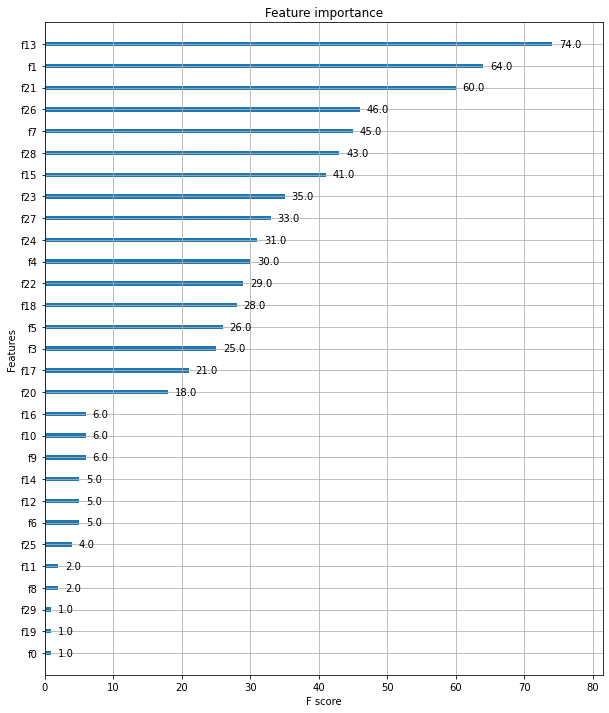

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

xgboost 모듈의 to_graphviz() : 규칙 트리 구조를 그릴 수 있음

- params(dict) : 부스터 파라미터
- dtrain(DMatrix) : 학습 데이터
- num_boost_round(int) : 부스팅 반복 횟수
- nfold(int) : CV 폴드 개수
- stratified(bool) : CV 수행 시 층화 표본 추출 수행 여부
- metrics(string or list of strings) : CV 수행 시 모니터링할 성능 평가 지표
- early_stopping_rounds(int) : 조기 중단을 활성화시킴, 반복횟수 지정

In [ ]:
xgboost.cv(params, dtrain, num_boost_round = 10, nfold = 3, stratified = False, 
           folds = None, metrics= (), obj = None, feval = None, maximize = False, 
           early_stopping_rounds = None, fpreproc = None, as_pandas = True, 
           verbose_eval = None, show_stdv = True, seed = 0, callbacks = None, 
           shuffle = True)

[10:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[10:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "early_stoppings" } might not be use

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.610037,0.000064,0.617448,0.004961
1,0.541817,0.000203,0.555140,0.008989
2,0.483717,0.000955,0.503529,0.012238
3,0.434676,0.001311,0.459869,0.015795
4,0.392310,0.001686,0.423058,0.016788
5,0.355129,0.001390,0.391187,0.019785
6,0.322530,0.001909,0.361119,0.019378
7,0.294159,0.001618,0.337139,0.021085
8,0.269083,0.002068,0.314902,0.019971
9,0.246208,0.001940,0.295012,0.019237


### 사이킷런 래퍼 XGBoost의 개요 및 적용 ###

- fit()과 predict() 만으로 학습과 예측 가능, GridSearchCV, Pipeline 등 사이킷런의 다른 유틸리티를 그대로 사용할 수 있음
- 분류를 위한 래퍼 클래스 XGBClassifier, 회귀를 위한 래퍼 클래스 XGBRegressor

기존의 xgboost 모듈에서 사용하던 네이티브 하이퍼 파라미터 변경

- eta -> learning_rate
- sub_sample -> subsample
- lambda -> reg_lambda
- alpha -> reg_alpha

n_estimators와 num_boost_roung 하이퍼 파리미터는 동일한 파라미터

- 두 개가 동시에 사용되면 
    - 파이썬 래퍼 XGBoost API에서는 n_estimators 파라미터를 무시하고 num_boost_round 파라미터 적용
    - XGBClassifier와 같은 사이킷런 래퍼 XGBoost 클래스에서는 n_estimators 적용

In [ ]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[10:57:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도 : 0.973684, 정밀도 : 0.974359, 재현율 : 0.987013,F1 : 0.980645, AUC :0.995086


조기 중단

- 조기 중단 관련 파라미터를 fit()에 입력하면 됨
- 조기 중단 관련 파라미터 : early_stopping_rounds, eval_metric, eval_set
- 성능 평가를 수행할 데이터 세트는 학습 데이터가 아니라 별도의 데이터 세트여야 함

In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric='logloss',
               eval_set = evals, verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [ ]:
get_clf_eval(y_test, ws100_preds, ws100_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도 : 0.964912, 정밀도 : 0.962025, 재현율 : 0.987013,F1 : 0.974359, AUC :0.995437


In [ ]:
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10, eval_metric='logloss',
               eval_set = evals, verbose=True)
ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15473
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [ ]:
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도 : 0.956140, 정밀도 : 0.961538, 재현율 : 0.974026,F1 : 0.967742, AUC :0.994735


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

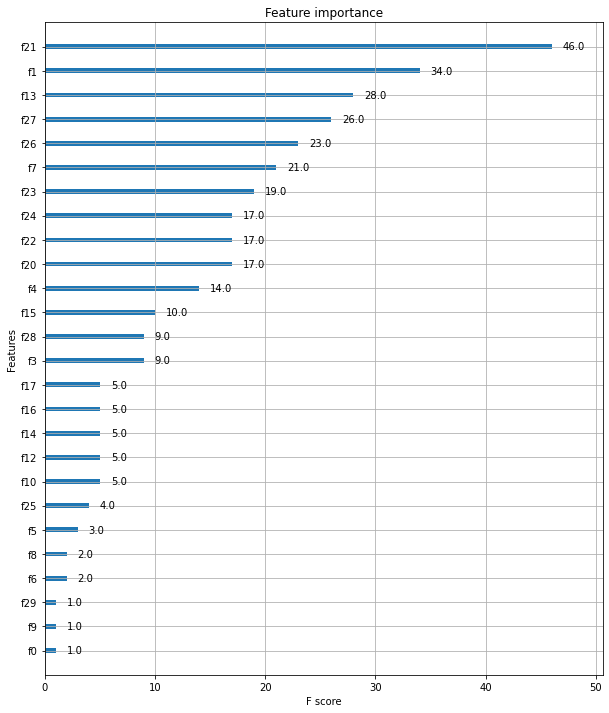

In [ ]:
fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 wrapper 클래스를 입력해도 무방
plot_importance(xgb_wrapper, ax=ax)

## 7. LightGBM ###

장점

- XGBoost보다 학습에 걸리는 시간이 훨씬 적음, 메모리 사용량도 상재겅르ㅗ 적음
- XGBoost와 예측 성능은 별다른 차이가 없음
- 기능상의 다양성이 약간 더 많음
- 카테고리형 피처의 자동변환과 최적분할(원=핫 인코딩 등을 사용하지 않고도 카테고리형 피처를 최적으로 변환하고 이에 따른 노드 분할 수행)

단점 : 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉬움 (10,000건 이하의 데이터 세트 정도)

리프 중심 트리 분할 방식 사용 
- 기존의 대부분의 트리 기반 알고리즘은 트리의 깊이를 효과적으로 줄이기 위한 균형 트리 분할 방식을 사용 : 오버피팅에 더 강한 구조를 가질 수 있으나 균형을 맞추기 위한 시간이 필요함
- 리프 중심 트리 분할 방식은 트리의 균형을 맞추지 않고, 최대 손실 값을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성됨, 균형 트리 분할 방식보다 예측 오류 손실을 최소화

### LightGBM 하이퍼 파라미터 ###

**주요 파라미터**

- num_iterations[default=100] : 반복 수행하려는 트리의 개수 지정
    - 크게 지정할수록 예측 성능이 높아질 수 있음
    - 너무 크게 지정하면 오히려 과적합으로 성능 저하
- learning_rate [default = 0.1] : 0과 1 사이의 값을 지정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값
    - 일반적으로 n_estimators를 크게 하고 learning_rate를 작게 해서 예측 성능을 향상시킬 수 있으나, 마찬가지로 과적합 이슈와 학습 시간이 길어지는 부정적인 영향도 고려해야
- max_depth default = -1] : 트리 기반 알고리즘의 max_dept와 같음
     - 0보다 작은 값을 지정하면 깊이에 제한 X
     - Leaf wise 기반이므로 길이가 상대적으로 깊음
- min_data_in_leaf [default = 20] : 결정 트리의 min_samples_leaf와 같음
    - LightGBMClassifier에서는 mln_child_samples 파라미터로 이름 변경
- num_leaves [ default = 31] : 하나의 트리가 가질 수 있는 최대 리프 개수
- boosting [ default = gbdt] : 부스팅의 트리를 생성하는 알고리즘 기술
    - gbdt : 일반적인 그래디언트 부스팅 결정 트리
    - rt : 랜덤 포레스트
- bagging_fraction [ default = 1.0] : 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율
- feature_fraction [default=1.0] : 개별 트리를 학습할 때마다 무직위로 선택하는 피처의 비율, 과적합 막기 위해 사용
- lambda_l2 [ default=0.0] : L2 regulation 제어를 위한 값, 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음
- lambda_l1[default = 0.0] : L1 regulation제어를 위한 값

**Learning Task 파라미터**

- objective : 최솟값을 가져야 할 손실함수 정의


### 하이퍼 파라미터 튜닝 방안 ###

- num_leaves : 개별 트리가 가질 수 있는 최대 리프의 개수, 모델의 복잡도 제어
    - 개수를 높이면 정확도가 높아지지만, 트리가 깊어지고 모델의 복잡도가 커져 과적합 영향도 커짐
- min_data_in_leaf : 과적합을 개선하기 위한 중요 파라미터, num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지
    - 사이킷런 래퍼 클래스에서는 min_child_samples로 이름이 바뀜
- max_depth : 깊이의 크기 제한, 과적합 개선하는 데 사용
- learning_rate를 작게 하면서 n_estimators를 크게 하는 것 (n_estimators 너무 크게하면 과적합으로 성능 저하)
- reg_lambda, reg_alpha와 같은 regularization을 적용하거나, colsample_bytree, subsample 파라미터 적용


### 파이썬 래퍼 LightGBM과 사이킷런 래퍼 XGBoost, LightBGM 하이퍼 파라미터 비교 ###

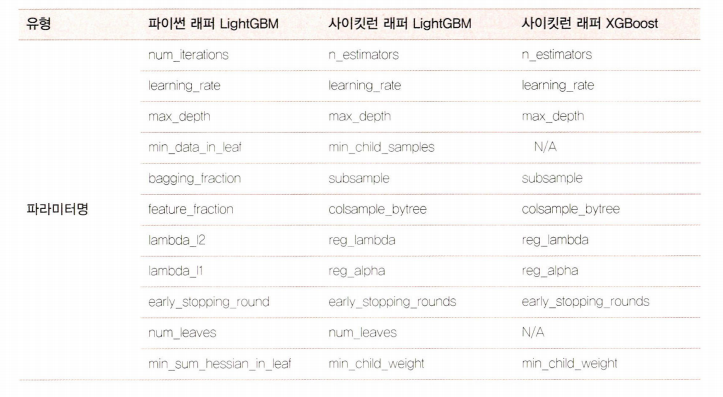

### LightGBM 적용 - 위스콘신 유방암 예측 ###

In [ ]:
conda install -c conda-forge lightgbm

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# LightGBM의 파이썬 패키지인 lightbgm엥서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80% 학습용, 20% 테스트용
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size=0.2, 
                                                   random_state=156)

#앞서 XGBoost와 동일하게 n_estimators는 400 설정
lgbm_wrapper = LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, early_stopping_rounds = 100,
                eval_metric='logloss', eval_set = evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
pred_proba=lgbm_wrapper.predict_proba(X_test)[:,1]

[1]	valid_0's binary_logloss: 0.565079
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355773
[7]	valid_0's binary_logloss: 0.329587
[8]	valid_0's binary_logloss: 0.308478
[9]	valid_0's binary_logloss: 0.285395
[10]	valid_0's binary_logloss: 0.267055
[11]	valid_0's binary_logloss: 0.252013
[12]	valid_0's binary_logloss: 0.237018
[13]	valid_0's binary_logloss: 0.224756
[14]	valid_0's binary_logloss: 0.213383
[15]	valid_0's binary_logloss: 0.203058
[16]	valid_0's binary_logloss: 0.194015
[17]	valid_0's binary_logloss: 0.186412
[18]	valid_0's binary_logloss: 0.179108
[19]	valid_0's binary_logloss: 0.174004
[20]	valid_0's binary_logloss: 0.167155
[21]	valid_0's binary_logloss: 0.162494
[22]	valid_0's binary_logloss: 0.156886
[23]	valid_0's binary_logloss: 0.152855
[24]	valid_0's binary_logloss: 0.151113
[25]	valid_0's binary_logloss: 0.148395
[26]	vali

In [ ]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[33  4]
 [ 1 76]]
정확도 : 0.956140, 정밀도 : 0.950000, 재현율 : 0.987013,F1 : 0.968153, AUC :0.990523


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

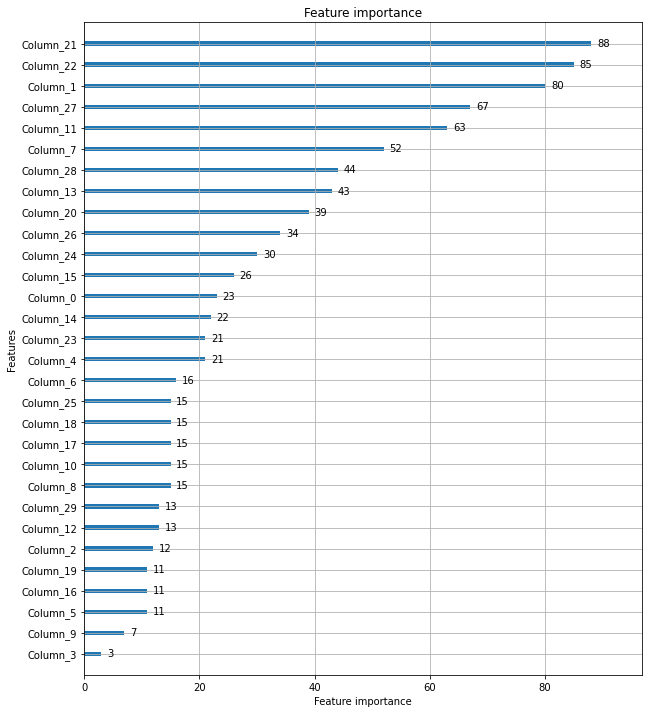

In [ ]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

## 10. 스태킹 앙상블 ###

스태킹 : 개별적인 여러 알고리즘을 서로 결합해 에측 결과를 도출, 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행, 여러 개의 모델에 대한 예측값을 합한 후, 이에 대한 예측을 다시 수행ㅈ

- 개별적인 기반 모델
- 최종 메타 모형 : 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습

스태킹을 적용할 때는 많은 개별 모델이 필요 


**기본 스태킹 모델**

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data=cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, 
                                                   random_state=0)

In [ ]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

# 개별 모댈들을 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train,y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [ ]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도 : {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도 : {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도 : 0.9211
랜덤 포레스트 정확도 : 0.9649
결정 트리 정확도 : 0.9123
에이다부스트 정확도 : 0.9561


In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환, 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [ ]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메탈 모델의 정확도 : {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메탈 모델의 정확도 : 0.9649


**CV 세트 기반의 스태킹**

과적합을 개선하기 위해 최종 메타 모델을 위한 데이터 세트를 만들 때 교차검증기반으로 예측된 결과 데이터 세트를 이용

- 스탭 1 : 각 모델별로 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습용/테스트용 데이터를 생성
- 스탭 2 : 스탭1에서 개별 모델들이 생성한 학습용 데이터를 모두 스테킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트를 생성, 마찬가지로 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트를 생성, 메타 모델을 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습한 뒤, 최종적으로 생성된 테스트 데이터 세트를 예측하고 원본 데이터의 레이블 데이터를 기반으로 평가

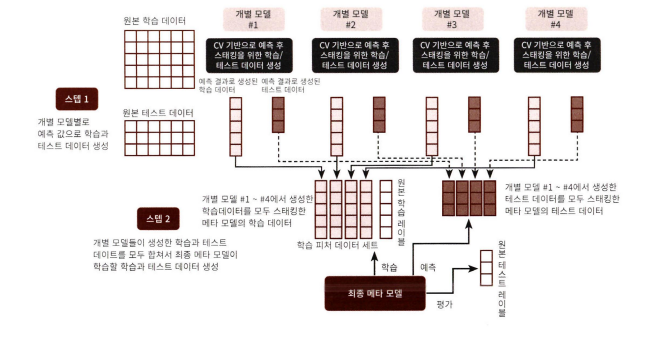

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    #지정된 n_folds값으로 KFold 생성
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = 0)
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__,'model 시작')

    for folder_counter, (train_index,valid_index) in enumerate(kf.split(X_train_n)) :
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t 폴드 세트 :', folder_counter, '시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(X_tr,y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[valid_index,:] = model.predict(X_te).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:,folder_counter] = model.predict(X_test_n)
    #폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis = 1).reshape(-1,1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean
    

In [ ]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
RandomForestClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
DecisionTreeClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작
AdaBoostClassifier model 시작
	 폴드 세트 : 0 시작
	 폴드 세트 : 1 시작
	 폴드 세트 : 2 시작
	 폴드 세트 : 3 시작
	 폴드 세트 : 4 시작
	 폴드 세트 : 5 시작
	 폴드 세트 : 6 시작


In [ ]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test =np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape : ', X_train.shape, 
      '원본 테스트 피처 Shape : ', X_test.shape)
print('스태킹 학습 피처 데이터 Shape : ', Stack_final_X_train.shape, 
      '스태킹 테스트 피처 Shape : ', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape :  (455, 30) 원본 테스트 피처 Shape :  (114, 30)
스태킹 학습 피처 데이터 Shape :  (455, 4) 스태킹 테스트 피처 Shape :  (114, 4)


In [ ]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도 : {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도 : 0.9649


## 11. 정리 ##

결정 트리 알고리즘 : 정보의 균일도에 기반한 규칙 트리를 만들어서 예측을 수행
앙상블 기법 : 배깅과 부스팅
- 배깅 : 학습 데이터를 중복을 허용하면서 다수의 세트로 샘플링하여 이를 다수의 약한 학습기가 학습한 뒤 최종 결과를 결합해 예측하는 방식
- 부스팅 : 학습기들이 순차적으로 학습을 진행하면서 예측이 틀린 데이터에 대해서는 가중치를 부여해 다음번 학습기가 학습할 때에는 이전에 예측이 틀린 데이터에 대해서는 보다 높은 정확도로 예측할 수 있도록 해줌
XGBoost, LightGBM 
스태킹 모델 : 여러 개의 개별 모델들이 생성한 예측 데이터를 기반으로 최종 메타 모델이 학습할 별도의 학습 데이터 세트와 예측할 테스트 데이터 세트를 재 생성하는 기법